In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import numpy as np
from tqdm.auto import tqdm

from preprocessing import tokenize, embeddings

/home/local_arnab/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [3]:
df = pd.read_csv("Data/df_lyrics.csv")
print(df.shape)
df.head()

(80285, 4)


,Artist,Song,Lyrics,Genre
0,Britney Spears,...Baby One More Time,"Oh, baby, baby Oh, baby, baby Oh, baby, baby...",Pop
1,Britney Spears,Toxic,"Baby, can't you see I'm calling? A guy like y...",Pop
2,Britney Spears,Work Bitch,You wanna? You wanna? You want a hot body? Y...,Pop
3,Britney Spears,Oops!... I Did It Again,"Mmm, yeah Yeah, yeah, yeah, yeah, yeah, yeah ...",Pop
4,Britney Spears,If U Seek Amy,"La, la, la, la, la-la, la, la La, la, la, la,...",Pop


In [4]:
for genre in set(df.Genre):
    print(genre, df[df.Genre == genre].shape[0])

Rap 18331
Country 21717
Pop 18275
Rock 21962


## Preprocessing

In [5]:
tokenizer = tokenize.Tokenizer()
tokenizer.load(path = "Weights/tokenizer.json")
tokenizer.tokenize("I'm a little teapot", get_token_ids=True)

2023-04-10 00:26:34.876114: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


{'tokens': [['<s>', 'I', '_am', '_a', '_little', '_te', 'ap', 'ot', '</s>']],
 'token_ids': [[0, 432, 51, 57, 778, 2153, 1821, 6834, 87]]}

In [6]:
##########################################################
MAX_LENGTH = 1024  # max context length for the tokenizer
##########################################################
lyrics = [l[:min(len(l), MAX_LENGTH)] for l in list(df["Lyrics"])]

proprocessed_lyrics = tokenizer.tokenize(lyrics, get_token_ids=True)

In [7]:
lyrics_token_ids = proprocessed_lyrics["token_ids"]
len(lyrics_token_ids)

80285

In [8]:
shuffle_idx = np.random.permutation(len(lyrics_token_ids))

####################################################################
training_size = 45000
validation_size = 15000
test_size = len(lyrics_token_ids) - training_size - validation_size
####################################################################

training_data = [lyrics_token_ids[i] for i in shuffle_idx[:training_size]]
validation_data = [lyrics_token_ids[i] for i in shuffle_idx[training_size : training_size + validation_size]]
test_data = [lyrics_token_ids[i] for i in shuffle_idx[training_size + validation_size : ]]

print(len(training_data), len(validation_data), len(test_data))

45000 15000 20285


In [9]:
embedder = embeddings.Embedding()
embedder.load("Weights/embeddings_300_w2v.txt")

In [10]:
embedder.embeddings_size

300

In [11]:
embedder.vocab_size

39903

In [12]:
embedding_matrix = []

for idx in tokenizer.index_word:
    word = tokenizer.index_word[idx]
    vec = embedder.model.get_vector(word)
    embedding_matrix.append(torch.tensor(vec))

embedding_matrix = torch.stack(embedding_matrix)
embedding_matrix.shape

torch.Size([39903, 300])

## Modeling

In [13]:
class RNN(torch.nn.Module):
    def __init__(
            self, 
            embedding_dim, hidden_dim, vocab_size, num_layers = 2,
            pretrained_embeddings = None, # will initialize with random embeddings if None
            dropout = 0.1,
        ):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim = embedding_dim)
        if(pretrained_embeddings != None):
            self.word_embeddings.weight = torch.nn.Parameter(pretrained_embeddings)
        self.dropout = torch.nn.Dropout(dropout)
        self.rnn = torch.nn.RNN(
            input_size = embedding_dim, 
            hidden_size = hidden_dim,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout,
        )
        self.decoder = torch.nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, input, hidden):
        embeds = self.word_embeddings(input)
        embeds = self.dropout(embeds)
        output, hidden = self.rnn(embeds, hidden)
        decoded = self.decoder(output)
        return decoded, hidden

In [14]:
class LSTM(torch.nn.Module):
    def __init__(
            self, 
            embedding_dim, hidden_dim, vocab_size, num_layers = 2,
            pretrained_embeddings = None, # will initialize with random embeddings if None
            dropout = 0.1,
        ):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim = embedding_dim)
        if(pretrained_embeddings != None):
            self.word_embeddings.weight = torch.nn.Parameter(pretrained_embeddings)
        self.dropout = torch.nn.Dropout(dropout)
        self.lstm = torch.nn.LSTM(
            input_size = embedding_dim, 
            hidden_size = hidden_dim,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout,
        )
        self.decoder = torch.nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, input, hidden):
        embeds = self.word_embeddings(input)
        embeds = self.dropout(embeds)
        output, hidden = self.lstm(embeds, hidden)
        decoded = self.decoder(output)
        return decoded, hidden

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = LSTM(
    embedding_dim = embedder.embeddings_size,
    hidden_dim = 4 * embedder.embeddings_size,
    vocab_size = embedder.vocab_size,
    pretrained_embeddings = embedding_matrix,
)
model.to(device)

LSTM(
  (word_embeddings): Embedding(39903, 300)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(300, 1200, num_layers=2, batch_first=True, dropout=0.1)
  (decoder): Linear(in_features=1200, out_features=39903, bias=True)
)

In [16]:
next(model.parameters()).device

device(type='cuda', index=0)

In [17]:
model_embedder = model.word_embeddings
for p in model_embedder.parameters():
    print(p.shape)

torch.Size([39903, 300])


In [18]:
word = "hello"
emb1 = embedder.model.get_vector(word)
emb2 = model_embedder(torch.tensor(tokenizer.word_index[word]).to(device))

print(emb1.shape, emb2.shape)
print(torch.dist(torch.tensor(emb1).to(device), emb2).item())

(300,) torch.Size([300])
0.0


In [19]:
tokenized = tokenizer.tokenize(lyrics[0:5], get_token_ids=True)["token_ids"]
min_length = np.array([len(t) for t in tokenized]).min()
batch = torch.stack(
    [torch.tensor(t[:min_length]) for t in tokenized]
)
batch.shape

torch.Size([5, 270])

In [20]:
# y, h = rnn(
#     input = torch.tensor([[tokenizer.word_index[word]]]).to(device), 
#     hidden = torch.zeros(8, 1, model.hidden_dim).to(device)
# )

y, (h, c) = model(
    input = batch[:, 10][None].T.to(device),
    # input = batch.to(device),
    hidden = None
)

y.shape, h.shape, c.shape

(torch.Size([5, 1, 39903]), torch.Size([2, 5, 1200]), torch.Size([2, 5, 1200]))

In [21]:
batch[:, 10][None].T.shape

torch.Size([5, 1])

In [22]:
# cross_entropy(y.squeeze(), torch.tensor(10).to(device))

In [23]:
isinstance(model, LSTM)

True

## Intrinsic Eval

In [24]:
def perplexity(
        model, sentence_list,
        tokenizer = None,  # if None, assume sentence_list is already tokenized
        batch_size = 32,
        consider_length = 32,   # if the length is too large the perplexity will be infinite
    ):
    model.eval()
    device = next(model.parameters()).device
    if(tokenizer is not None):
        tokenized = tokenizer.tokenize([sentence_list], get_token_ids=True)
        token_ids = tokenized["token_ids"][0]
    else:
        token_ids = sentence_list

    perplexity_track = []
    with torch.no_grad():
        for batch_start in tqdm(range(0, len(token_ids), batch_size)):
            batch_end = min(len(token_ids), batch_start + batch_size)
            cur_batch_size = batch_end - batch_start
            min_length = min(consider_length, np.array([len(t) for t in token_ids[batch_start : batch_end]]).min())

            batch = torch.stack(
                [torch.tensor(t[:min_length]) for t in token_ids[batch_start : batch_end]]
            ).to(device)

            if(isinstance(model, LSTM)):
                hidden_state = (
                    torch.zeros(model.num_layers, cur_batch_size, model.hidden_dim).to(device),
                    torch.zeros(model.num_layers, cur_batch_size, model.hidden_dim).to(device)
                )
            elif(isinstance(model, RNN)):
                hidden_state = torch.zeros(model.num_layers, cur_batch_size, model.hidden_dim).to(device)
            else:
                raise Exception("Unknown model type")

            # print(batch.shape, hidden_state.shape)

            log_true_proba = 0
            for i in range(min_length - 1):
                x = batch[:, i][None].T
                y_true = batch[:, i+1][None].T
                y_pred, hidden_state = model(x, hidden_state)
                cur_log_proba = 0
                for pred, true in zip(y_pred, y_true):
                    softmax = torch.nn.functional.softmax(pred.squeeze(), dim = 0)
                    # print(true[0].item(), softmax[true[0]].item(), torch.log(softmax[true[0]]).item())
                    cur_log_proba += torch.log(softmax[true[0]])
                cur_log_proba /= cur_batch_size
                # print(cur_log_proba.item())
                log_true_proba += cur_log_proba

                # hidden_state = hidden_state.detach()

            proba = torch.exp(log_true_proba.to(torch.float64))
            # print(f"log proba = {log_true_proba.item()}", f"p = {proba.item()}")
            perplexity_track.append(torch.pow(proba, -1/min_length))
    
    return torch.tensor(perplexity_track).mean().item()
        

init_perplexity = perplexity(
    model, validation_data, batch_size = 128, consider_length = 64
)

perplexity_track = [init_perplexity]

100%|██████████| 118/118 [00:47<00:00,  2.47it/s]


In [25]:
perplexity_track

[33193.54416127695]

## Training

In [26]:
learning_rate = 0.001
num_epochs = 10
batch_size = 128

cross_entropy = torch.nn.CrossEntropyLoss().to(device)
tunable_params = [
    p for n, p in model.named_parameters() if "word_embeddings" not in n # tune all weights but the embeddings
]

optimizer = torch.optim.Adam(tunable_params, lr = learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [27]:
batch_start = 0
batch_end = batch_start + batch_size
tokenized = training_data[batch_start : batch_end]

In [28]:
loss_track = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}:")
    model.train()
    loss = 0
    for batch_start in tqdm(range(0, len(training_data), batch_size)):
        batch_end = min(len(training_data), batch_start + batch_size)
        cur_batch_size = batch_end - batch_start

        tokenized = training_data[batch_start : batch_end]
        min_length = np.array([len(t) for t in tokenized]).min()
        batch = torch.stack(
            [torch.tensor(t[:min_length]) for t in tokenized]
        ).to(device)

        # start fresh for each sentence
        if(isinstance(model, LSTM)):
            hidden_state = (
                torch.zeros(model.num_layers, cur_batch_size, model.hidden_dim).to(device),
                torch.zeros(model.num_layers, cur_batch_size, model.hidden_dim).to(device)
            )
        elif(isinstance(model, RNN)):
            hidden_state = torch.zeros(model.num_layers, cur_batch_size, model.hidden_dim).to(device)
        else:
            raise Exception("Unknown model type")
        
        for i in range(min_length - 1):
            x = batch[:, i][None].T
            y_true = batch[:, i+1][None].T
            y_pred, hidden_state = model(x, hidden_state)
            for pred, true in zip(y_pred, y_true):
                loss += cross_entropy(pred.squeeze(), true[0])
        
        loss_track.append(loss.item()/cur_batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        model.zero_grad()
        loss = 0
    
    print("calculating perplexity on validation set")
    pp = perplexity(model, validation_data, batch_size=batch_size, consider_length=64)
    print(f"perplexity = {pp}") 
    perplexity_track.append(pp)
    print("-----------------------------------------")

Epoch 1:


100%|██████████| 352/352 [04:31<00:00,  1.30it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


perplexity = 465.906510884181
-----------------------------------------
Epoch 2:


100%|██████████| 352/352 [04:31<00:00,  1.29it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


perplexity = 192.0857389768086
-----------------------------------------
Epoch 3:


100%|██████████| 352/352 [04:31<00:00,  1.29it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


perplexity = 143.7444118541959
-----------------------------------------
Epoch 4:


100%|██████████| 352/352 [04:33<00:00,  1.29it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


perplexity = 122.67556105502022
-----------------------------------------
Epoch 5:


100%|██████████| 352/352 [04:32<00:00,  1.29it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


perplexity = 111.65434190430754
-----------------------------------------
Epoch 6:


100%|██████████| 352/352 [04:32<00:00,  1.29it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


perplexity = 104.54861522325913
-----------------------------------------
Epoch 7:


100%|██████████| 352/352 [04:32<00:00,  1.29it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.36it/s]


perplexity = 99.98729889668567
-----------------------------------------
Epoch 8:


100%|██████████| 352/352 [04:33<00:00,  1.29it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


perplexity = 97.3643912561705
-----------------------------------------
Epoch 9:


100%|██████████| 352/352 [04:32<00:00,  1.29it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


perplexity = 96.2088717253703
-----------------------------------------
Epoch 10:


100%|██████████| 352/352 [04:33<00:00,  1.29it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]

perplexity = 95.08838721486693
-----------------------------------------


In [34]:
import os
import json

save_dir = "Weights/lstm_embed_freeze"
os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), f"{save_dir}/weights.pth")
with open(f"{save_dir}/logs.json", "w") as f:
    json.dump({
        "loss_track": loss_track,
        "perplexity_track": perplexity_track
    }, f)

Text(0, 0.5, 'Loss')

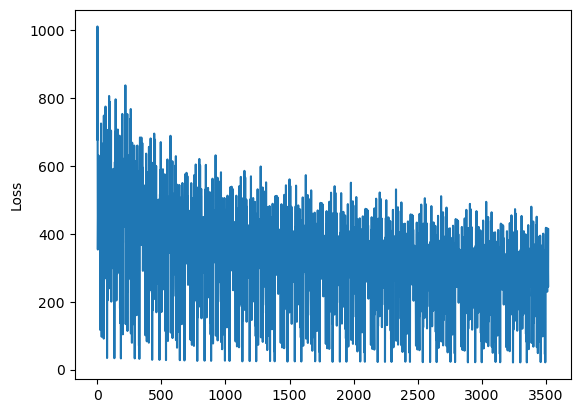

In [42]:
import matplotlib.pyplot as plt

plt.plot(loss_track)
plt.ylabel("Loss")

Text(0.5, 0, 'Epoch')

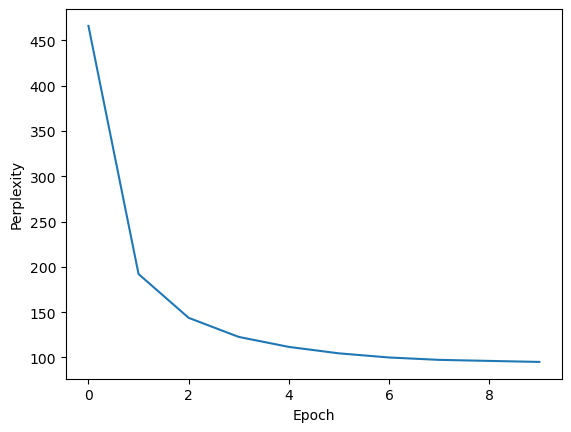

In [40]:
plt.plot(perplexity_track[1:])
plt.ylabel("Perplexity")
plt.xlabel("Epoch")

## Generation

In [38]:
def generate(
        model, tokenizer, 
        prompt="", max_new_tokens = 10, top_k = 5,
        debug = False,
    ):
    model.eval()
    device = next(model.parameters()).device
    tokenized = tokenizer.tokenize([prompt], get_token_ids=True)
    token_ids = tokenized["token_ids"][0][:-1]  # remove the </s> token
    end_of_sent = tokenizer.word_index[tokenizer.SENT_END]

    # start fresh for each sentence
    if(isinstance(model, LSTM)):
        hidden_state = (
            torch.zeros(model.num_layers, 1, model.hidden_dim).to(device),
            torch.zeros(model.num_layers, 1, model.hidden_dim).to(device)
        )
    elif(isinstance(model, RNN)):
        hidden_state = torch.zeros(model.num_layers, 1, model.hidden_dim).to(device)
    else:
        raise Exception("Unknown model type")
    
    for p in token_ids:
        x = torch.tensor([[p]]).to(device)
        y_pred, hidden_state = model(x, hidden_state)
    
    last_token = token_ids[-1]
    generated_tokens = []
    for i in range(max_new_tokens):
        # print(hidden_state.norm().item())
        y_pred, hidden_state = model(
            torch.tensor([[last_token]]).to(device), hidden_state
        )
        y_pred = y_pred.squeeze()
        y_pred = torch.nn.functional.softmax(y_pred, dim = 0)
        y_pred = y_pred.cpu().detach().numpy()
        top_k_idx = y_pred.argsort()[-top_k:][::-1]
        top_k_values = y_pred[top_k_idx]

        if(debug):
            print(top_k_idx)
            print([(tokenizer.index_word[t], np.round(v, 4)) for t, v in zip(top_k_idx, top_k_values)])
        
        top_k_probs = top_k_values / np.sum(top_k_values)
        sampled_idx = np.random.choice(top_k_idx, p = top_k_probs)
        token_ids.append(sampled_idx)
        last_token = sampled_idx
        generated_tokens.append(sampled_idx)
        if(sampled_idx == end_of_sent):
            break
    
    return {
        "text": tokenizer.decode([token_ids + generated_tokens]),
        "generated_tokens": generated_tokens,
    }

In [39]:
gen_lyrics = generate(model, tokenizer, top_k = 10, max_new_tokens=50, debug = True)
gen_lyrics["text"]

[ 479    4  432    7 1288 3453  210 1874 1378  257]
[('You', 0.0399), ('_', 0.0356), ('I', 0.0304), ('_I', 0.0279), ('When', 0.0227), ('There', 0.0208), ('_Yeah', 0.0183), ('Hey', 0.0178), ('A', 0.0148), ('_"', 0.0143)]
[ 24  68  10  18 493  89 477  75 117 916]
[('_are', 0.2671), ('_got', 0.065), ('_know', 0.0602), ('_have', 0.0482), ('_can', 0.0472), ('_cannot', 0.0237), ('_will', 0.023), ('_do', 0.0203), ('_and', 0.0171), ('_were', 0.0158)]
[  9  57  77  30  73 122  54 419 226 760]
[('_to', 0.4143), ('_a', 0.1681), ('_the', 0.0509), ('_me', 0.0395), ('_that', 0.0262), ('_your', 0.0243), ('_my', 0.016), ('_an', 0.0117), ('_so', 0.0106), ('_some', 0.0094)]
[ 21 179  34  18 344 345 281  90 785 494]
[('_go', 0.1493), ('_get', 0.1202), ('_be', 0.053), ('_have', 0.039), ('_make', 0.0265), ('_move', 0.0222), ('_take', 0.021), ('_see', 0.0205), ('_find', 0.0184), ('_keep', 0.0172)]
[  57   77  122 6080   54  264  226  147   25   73]
[('_a', 0.0905), ('_the', 0.0817), ('_your', 0.0769), ('_ca

['You got to be in your bed, you can see it is in your hands You cannot hide the air, the bones are wide The stars are open wide, the stars are open And it is not like you, you have to go It is notYou got to be in your bed, you can see it is in your hands You cannot hide the air, the bones are wide The stars are open wide, the stars are open And it is not like you, you have to go It is not']